In [2]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from gaussian_rbf_network_c import GaussianRBFNetworkC

In [34]:
from sklearn.datasets import make_classification

n_classes = 2

X, y = make_classification(n_samples=1000, n_features=2, n_classes=n_classes, n_clusters_per_class=1, 
                           n_redundant=0, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, random_state=42) 

scaler_X = StandardScaler()
X_train_st = scaler_X.fit_transform(X_train)
X_test_st = scaler_X.transform(X_test)

X_train_st, y_train = torch.from_numpy(X_train_st).float(), torch.from_numpy(y_train).float()
X_test_st, y_test = torch.from_numpy(X_test_st).float(), torch.from_numpy(y_test).float()

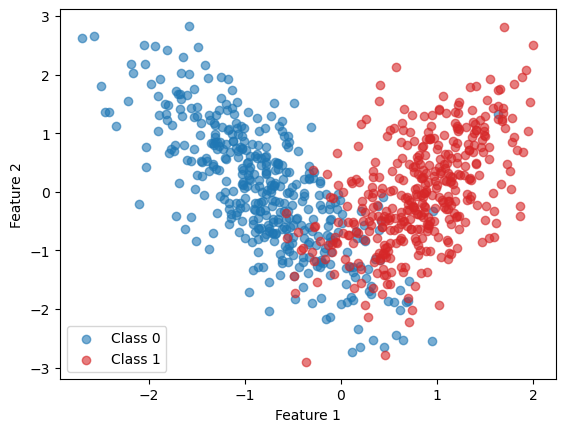

In [35]:
fig = plt.figure()
plt.scatter(X_train_st[:, 0][y_train==0.], X_train_st[:, 1][y_train==0.], c='tab:blue', label='Class 0', alpha=0.6)
plt.scatter(X_train_st[:, 0][y_train==1.], X_train_st[:, 1][y_train==1.], c='tab:red', label='Class 1',alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

In [42]:
n_centers, n_features = 2, X_train.shape[1]

kmeans = KMeans(n_clusters=n_centers, random_state=0, n_init='auto').fit(X_train_st)
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

model = GaussianRBFNetworkC(gaussian_regularizer=1e-3, 
                            centers_regularizer=1e-10, 
                            weights_regularizer=1e-10, centers=centers, 
                           n_features=n_features, n_centers=n_centers)

train_data = torch.utils.data.TensorDataset(X_train_st, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    total_loss = 0.0
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch', leave=False) as t:
        for batch_X, batch_y in t:
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(batch_X)

            # Compute loss
            loss = model.evaluate_loss(output, batch_y)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            t.set_postfix(loss=f'{total_loss / len(t):.4f}')  # Update the progress bar with the current loss


In [43]:
# Compute accuracy on training set
model.eval()
output_train = model(X_train_st)
predicted_train = (output_train > 0.5).float().numpy()


train_accuracy = accuracy_score(y_train, predicted_train)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Compute accuracy on test set
model.eval()
output_test = model(X_test_st)
predicted_test = (output_test > 0.5).float().numpy()

test_accuracy = accuracy_score(y_test, predicted_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 91.50%
Test Accuracy: 92.50%


In [48]:
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

In [50]:
eigenvectors

tensor([[ 0.1711, -0.9853],
        [-0.9853, -0.1711]], grad_fn=<LinalgEighBackward0>)

[0.44871977 0.44765386 0.4465695  ... 0.57402325 0.5726512  0.57129925]


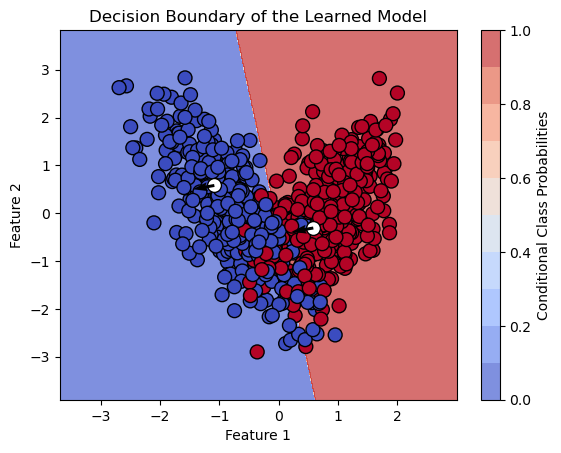

In [46]:
centers_opt = model.centers.detach().numpy()
D = X_train_st.size(1)  # Dimensionality of input data X

# Create a meshgrid of points in the input space
x_min, x_max = X_train_st[:, 0].min() - 1, X_train_st[:, 0].max() + 1
y_min, y_max = X_train_st[:, 1].min() - 1, X_train_st[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]

meshgrid_points_tensor = torch.tensor(meshgrid_points, dtype=torch.float32)

model.eval()

class_probabilities = model(meshgrid_points_tensor).detach().numpy()
print(class_probabilities)
predicted_labels = (class_probabilities > 0.5).astype(int)
#     else:
#         raise ValueError("Unsupported task type for plotting")

# Reshape the predicted labels to the shape of the meshgrid
predicted_labels = predicted_labels.reshape(xx.shape)

# Plot the decision boundary
contour = plt.contourf(xx, yy, predicted_labels, cmap=plt.cm.coolwarm, alpha=0.7, levels=np.arange(0, 1.1, 0.1))

# Plot the training data points and centers
plt.scatter(X_train_st[:, 0], X_train_st[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', s=100)
plt.scatter(centers_opt[:, 0], centers_opt[:, 1], edgecolors='k', marker='o', s=100, c='w')

cbar = plt.colorbar(contour)
cbar.set_label('Conditional Class Probabilities')

dominant_eigenvector = eigenvectors[:, -1].detach().numpy()
for center in centers:
    plt.quiver(center[0], center[1], dominant_eigenvector[0], dominant_eigenvector[1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of the Learned Model')
plt.show()

In [47]:
feature_importance

tensor([0.8520, 0.1480], grad_fn=<DivBackward0>)